In [2]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from visualization import state_visualization as state_vis

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# A notebook of examples of coherent state mle tomography working. 

# Included is tomography of a |0> + |1> superposition state, a coherent state |1 + i> and a thermal state of 4.4 photons

<IPython.core.display.Javascript object>


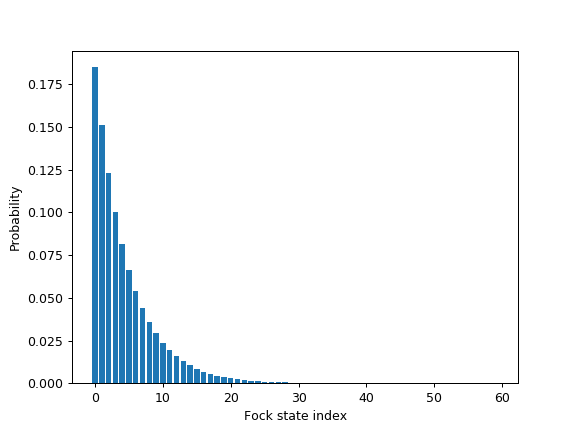

<IPython.core.display.Javascript object>


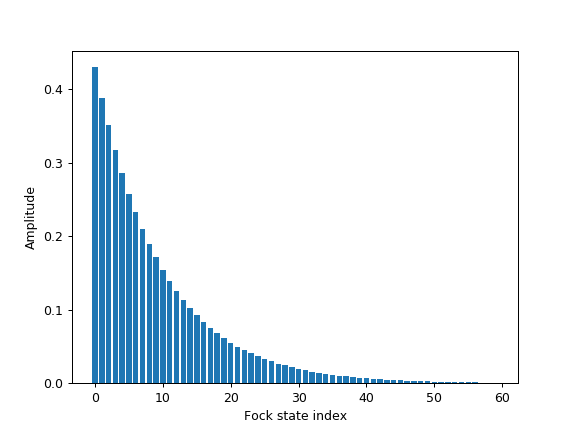

In [4]:
# The first example is the 4.4 photon average thermal state. For this tomographic reconstruction we use an ideal POVM
# because in reality this thermal state will represent the dark measurement of our detector, and thus the background
# noise. Its P function will then be extracted and used to perform a noisy POVM coherent state tomography of data.

# First we check to see how large a phase space square we'll need
dim = 60 # Generously large to ensure we resolve the entire thermal state
number_of_noise_photons = 4.4
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
state_vis.plot_fock_basis_probabilities(noise_state)
state_vis.plot_fock_basis_amplitudes(noise_state)

In [5]:
# From the above a square of half-width 6 and so a Fock space greater than 2*6^2 + sqrt(2)*6 ~ 85
max_x = 6
mesh_size = 0.5
number_of_noise_photons = 1
dim = 90

noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

# Define the input state and noiseless povm
input_state = qutip.thermal_dm(dim, number_of_noise_photons)
povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                        mesh_size, 
                                                        dim)

data_Q_function = qutip.qfunc(input_state, xs, ps, g=2)

# Perform MLE
number_of_mle_iterations = 100
s = time.time()
reconstructed_state, fidelities = cst.perform_coherent_state_MLE(
                                    povm,
                                    data_Q_function, 
                                    number_of_mle_iterations,
                                    rho_ideal=input_state)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 90: 34.359549045562744 s


In [ ]:
explicit_Q_function = cst.evaluate_Q_function(input_state, povm)
fig, ax = plt.subplots()
ax.pcolormesh(xs, ps, np.abs(data_Q_function))
print(explicit_Q_function)

<IPython.core.display.Javascript object>


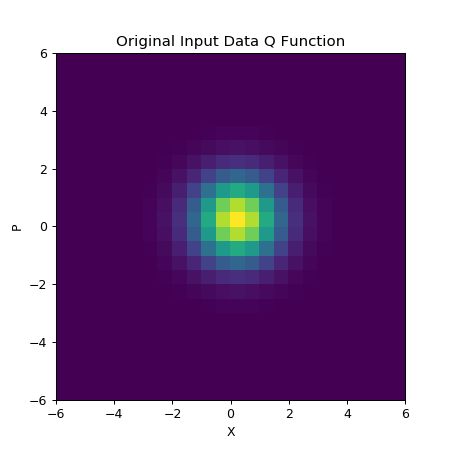

<IPython.core.display.Javascript object>


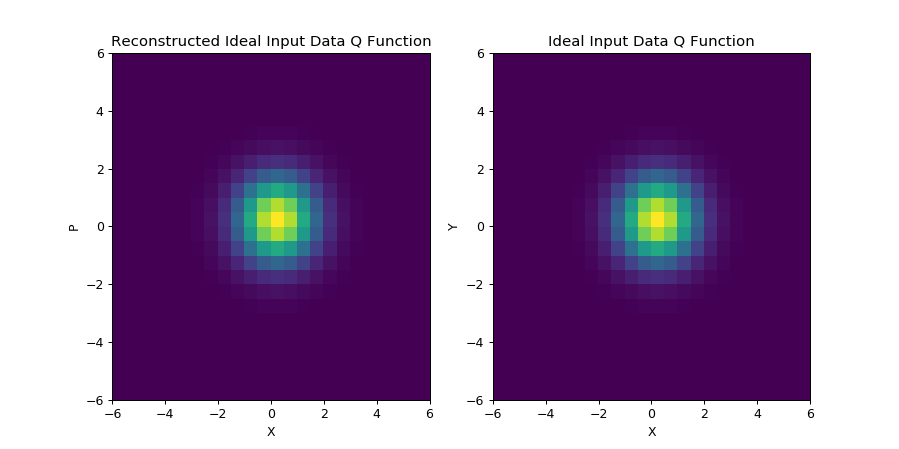

<IPython.core.display.Javascript object>


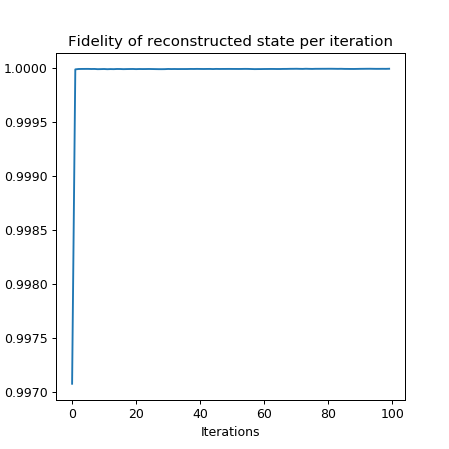

<IPython.core.display.Javascript object>


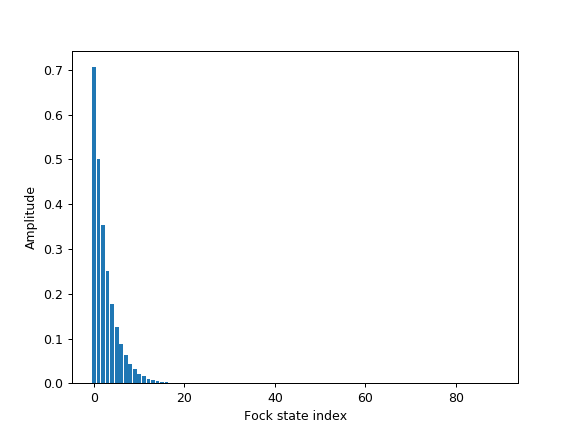

In [7]:
cst.plot_coherent_state_tomography_Q_functions(data_Q_function,
                                               reconstructed_state,
                                               xs,
                                               ps,
                                               ideal_state=input_state,
                                               fidelities=fidelities)
state_vis.plot_fock_basis_amplitudes(reconstructed_state)

# Next we assume the 4.4 photon background noise and try to reconstruct a coherent state |1 + 1i>

In [ ]:
input_alpha = 1 + 1j
input_coherent_state = qutip.coherent_dm(dim, input_alpha)
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
noise_qfunc = qutip.qfunc(noise_state, xs, ps, g=2)

# Construct a noisy POVM to use
noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base=noise_state)

# Generate the noisy data
ideal_coherent_qfunc = qutip.qfunc(coherent_input_state, xs, ps, g=2)
noisy_coherent_qfunc = cst.evaluate_thermally_noisy_Q_function(input_coherent_state, 
                                                               number_of_noise_photons, 
                                                               xs, 
                                                               ps)

# Perform noisy POVM MLE
# Perform MLE
number_of_mle_iterations = 100
s = time.time()
reconstructed_coherent_state, coherent_fidelities = \
    cst.perform_coherent_state_MLE(
        noisy_povm,
        noisy_coherent_qfunc, 
        number_of_mle_iterations,
        rho_ideal=input_coherent_state)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

In [ ]:
cst.plot_coherent_state_tomography_Q_functions(noisy_coherent_qfunc,
                                               reconstructed_coherent_state,
                                               xs,
                                               ps,
                                               noise_data=noise_qfunc,
                                               noise_photon_number=number_of_noise_photons,
                                               ideal_state=input_coherent_state,
                                               fidelities=coherent_fidelities)

# Finally we reconstruct the |0> + |1> superposition state afflicted by noise

In [ ]:
superposition_input_state = (qutip.basis(dim, 0) + qutip.basis(dim, 1))
superposition_input_state = qutip.ket_to_dm(superposition_input_state)
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
noise_qfunc = qutip.qfunc(noise_state, xs, ps, g=2)

# Construct a noisy POVM to use
noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base=noise_state)

# Generate the noisy data
ideal_superposition_qfunc = qutip.qfunc(coherent_input_state, xs, ps, g=2)
noisy_superposition_qfunc = cst.evaluate_thermally_noisy_Q_function(input_superposition_state, 
                                                               number_of_noise_photons, 
                                                               xs, 
                                                               ps)

# Perform noisy POVM MLE
# Perform MLE
number_of_mle_iterations = 2000
s = time.time()
reconstructed_superposition_state, superposition_fidelities = \
    cst.perform_coherent_state_MLE(
        noisy_povm,
        noisy_superposition_qfunc, 
        number_of_mle_iterations,
        rho_ideal=input_state)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

In [ ]:
cst.plot_coherent_state_tomography_Q_functions(noisy_superposition_qfunc,
                                               reconstructed_superposition_state,
                                               xs,
                                               ps,
                                               noise_data=noise_qfunc,
                                               noise_photon_number=number_of_noise_photons,
                                               ideal_state=input_state,
                                               fidelities=superposition_fidelities)